In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os

import random

from skimage.io import imread, imshow
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable
import cv2

from pathlib import Path
import nibabel as nib
from sklearn import preprocessing


import torchvision.models as models
from torchvision import datasets, models, transforms

# from torchsummary import sumarry

In [2]:
#https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
#         print(x.shape)
#         x = x.view(x.size(0), -1)
#         print('flat: ', x.shape)
        x = self.classifier(x)
#         print('before ret ', x.shape)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [5]:
def vgg19(pretrained=False, **kwargs):
    """VGG 19-layer model (configuration "E")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['E']), **kwargs)
    if pretrained:
        state_dict = torch.load('vgg19-dcbb9e9d.pth')
        model.load_state_dict(state_dict)
#         model.load_state_dict(model_zoo.load_url(model_urls['vgg19']))
    return model

In [6]:
model = vgg19(pretrained=True)
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [7]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [8]:
for param in model.parameters():
    param.requires_grad = False


model.features[-5] = nn.Conv2d(512,512,3, padding=1)
model.features[-3] = nn.Conv2d(512,2,3, padding=1)
    
model.classifier = nn.Sequential(
                                nn.AdaptiveAvgPool2d(1),Flatten(),
                                nn.LogSoftmax()
                                )

In [9]:
data_dir = "hymenoptera_data/"

In [11]:
# Data augmentation and normalization for training
# Just normalization for validation
batch_size =128
input_size=224
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [12]:
criterion = nn.CrossEntropyLoss()
lr =.00001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [15]:
def accuracy(out, labels):
#     print(out.data)
    total = 0.0
    out = F.softmax(out)
    _,predicted = torch.max(out, 1)
#     print(predicted)
#     labels_ = torch.argmax(labels.data)
#     print(labels.data)
    
#     print(predicted, labels.data)
    total += (predicted == labels.data).sum().item()
#     print(total, len(predicted))
    return total/len(predicted)

In [16]:
dataloaders = dataloaders_dict

mean_train_losses = []
mean_val_losses = []

mean_train_acc = []
mean_val_acc = []
minLoss = 99999
maxValacc = -99999
for epoch in range(100):
    print('EPOCH: ',epoch+1)
   
    train_acc = []
    val_acc = []
    
    running_loss = 0.0
    running_acc = 0.0
    
    model.train()
    count = 0
    for images, labels in dataloaders['train']:        
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        
#         print(images.shape)
        outputs = model(images) 
#         print(outputs)
#         print(labels)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        
        train_acc.append(accuracy(outputs, labels))
        
        loss.backward()
        optimizer.step()        
        
        running_loss += loss.item()
        count +=1
    
    print('Training loss:.......', running_loss/count)
#     print('Training accuracy:...', np.mean(train_acc))
    mean_train_losses.append(running_loss/count)
        
    model.eval()
    count = 0
    val_running_loss = 0.0
    for images, labels in dataloaders['val']:
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        val_acc.append(accuracy(outputs, labels))
        val_running_loss += loss.item()
        count +=1

    mean_val_loss = val_running_loss/count
    print('Validation loss:.....', mean_val_loss)
    
    print('Training accuracy:...', np.mean(train_acc))
    print('Validation accuracy..', np.mean(val_acc))
    
    mean_val_losses.append(mean_val_loss)
    
    mean_train_acc.append(np.mean(train_acc))
    
    val_acc_ = np.mean(val_acc)
    mean_val_acc.append(val_acc_)
    
   
    if mean_val_loss < minLoss:
        torch.save(model.state_dict(), 'bees.pth' )
        print(f'NEW BEST LOSS: {mean_val_loss} ........old best:{minLoss}')
        minLoss = mean_val_loss
        print('')
        
    if val_acc_ > maxValacc:
        torch.save(model.state_dict(), 'acc_bees.pth' )
        print(f'NEW BEST ACC: {val_acc_} ........old best:{maxValacc}')
        maxValacc = val_acc_
    
    
    print('')
    

EPOCH:  1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


Training loss:....... 0.6624489426612854
Validation loss:..... 0.6361678242683411
Training accuracy:... 0.7113415948275862
Validation accuracy.. 0.7267187500000001
NEW BEST: 0.6361678242683411 ........old best:99999

NEW BEST: 0.7267187500000001 ........old best:-99999

EPOCH:  2
Training loss:....... 0.6361916959285736
Validation loss:..... 0.6047700643539429
Training accuracy:... 0.802801724137931
Validation accuracy.. 0.81015625
NEW BEST: 0.6047700643539429 ........old best:0.6361678242683411

NEW BEST: 0.81015625 ........old best:0.7267187500000001

EPOCH:  3
Training loss:....... 0.6162295043468475
Validation loss:..... 0.575557678937912
Training accuracy:... 0.8278556034482758
Validation accuracy.. 0.86625
NEW BEST: 0.575557678937912 ........old best:0.6047700643539429

NEW BEST: 0.86625 ........old best:0.81015625

EPOCH:  4
Training loss:....... 0.5895026624202728
Validation loss:..... 0.5663261711597443
Training accuracy:... 0.8403825431034483
Validation accuracy.. 0.86578125


Training loss:....... 0.24276725202798843
Validation loss:..... 0.30855682492256165
Training accuracy:... 0.9217403017241379
Validation accuracy.. 0.9209375

EPOCH:  43
Training loss:....... 0.23569165915250778
Validation loss:..... 0.29463791847229004
Training accuracy:... 0.9428879310344828
Validation accuracy.. 0.90875

EPOCH:  44
Training loss:....... 0.2432805448770523
Validation loss:..... 0.21170077845454216
Training accuracy:... 0.9213362068965517
Validation accuracy.. 0.95703125
NEW BEST: 0.21170077845454216 ........old best:0.2576359435915947


EPOCH:  45
Training loss:....... 0.2379315048456192
Validation loss:..... 0.2655502110719681
Training accuracy:... 0.9264547413793103
Validation accuracy.. 0.92484375

EPOCH:  46
Training loss:....... 0.22423504292964935
Validation loss:..... 0.2798599600791931
Training accuracy:... 0.9303609913793103
Validation accuracy.. 0.92484375

EPOCH:  47
Training loss:....... 0.2204509824514389
Validation loss:..... 0.1953253336250782
Training 

Training loss:....... 0.15831368416547775
Validation loss:..... 0.19650990143418312
Training accuracy:... 0.9476023706896552
Validation accuracy.. 0.9409375

EPOCH:  90
Training loss:....... 0.12729456648230553
Validation loss:..... 0.31667397916316986
Training accuracy:... 0.9593211206896552
Validation accuracy.. 0.9409375

EPOCH:  91
Training loss:....... 0.14992467314004898
Validation loss:..... 0.2555773928761482
Training accuracy:... 0.9507004310344828
Validation accuracy.. 0.9409375

EPOCH:  92
Training loss:....... 0.12861139327287674
Validation loss:..... 0.3200824409723282
Training accuracy:... 0.9554148706896552
Validation accuracy.. 0.8926562499999999

EPOCH:  93
Training loss:....... 0.18096419423818588
Validation loss:..... 0.25637754052877426
Training accuracy:... 0.9381734913793103
Validation accuracy.. 0.92484375

EPOCH:  94
Training loss:....... 0.13611115142703056
Validation loss:..... 0.24661673605442047
Training accuracy:... 0.9467941810344828
Validation accuracy.. 

In [17]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

# Display class activation maps for a few examples

In [48]:
class SaveFeatures():
    features=None
    def __init__(self,m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output#.cpu().data().numpy()
    def remove(self): self.hook.remove()


In [95]:
dat = dataloaders_dict['train']
im, lab = next(iter(dat))

In [102]:
im[2].shape

torch.Size([3, 224, 224])

In [134]:
sf = SaveFeatures(model.features[-3])
indx = 11

img = im[indx].view(1,3,224,224)
img = Variable(img.cuda())
lab[indx] = Variable(lab[indx].cuda())
outputs = F.softmax(model(img))
_,pred = torch.max(outputs,1)

# print(pred.data.cpu().numpy()[0], lab[0].data.cpu().numpy())
if pred.data.cpu().numpy() == lab[indx].data.cpu().numpy():
    print('correct')  
    print('label', lab[indx].data)
else: print('wrong')

correct
label tensor(0)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


In [135]:
img.shape

torch.Size([1, 3, 224, 224])

In [136]:
img = img.data.cpu().numpy()
img = np.squeeze(img)
print(img.shape)
img = np.rollaxis(img, 0,3)
img.shape

(3, 224, 224)


(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


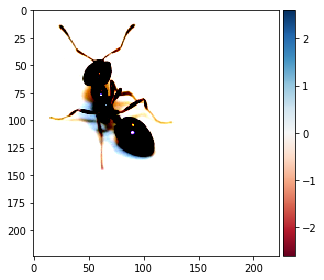

In [138]:
imshow(img)

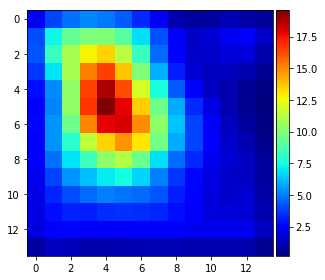

In [140]:
sf.remove()
arr = sf.features.cpu().detach().numpy()
arr1 = arr[0]
ans = np.dot(np.rollaxis(arr1,0,3), [1,0])
imshow(ans, cmap='jet')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


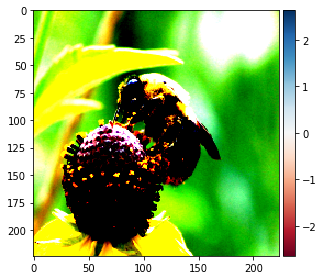

In [127]:
imshow(img)

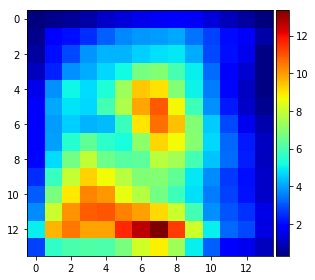

In [128]:
sf.remove()
arr = sf.features.cpu().detach().numpy()
arr1 = arr[0]
ans = np.dot(np.rollaxis(arr1,0,3), [0,1])
imshow(ans, cmap='jet')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


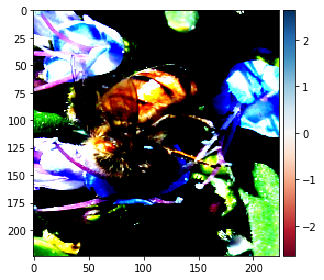

In [117]:
imshow(img)

/opt/conda/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


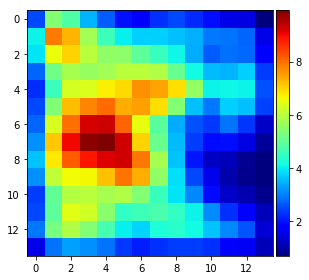

In [118]:
sf.remove()
arr = sf.features.cpu().detach().numpy()
arr1 = arr[0]
ans = np.dot(np.rollaxis(arr1,0,3), [0,1])
imshow(ans, cmap='jet')

In [119]:
a = resize(ans, (224,224))

/opt/conda/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

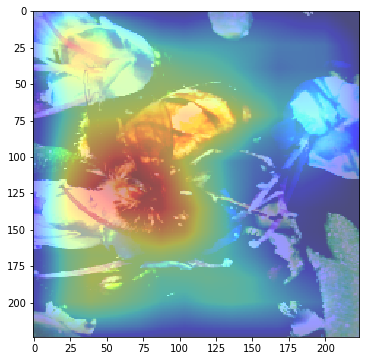

In [123]:
plt.figure()
plt.subplots(figsize=(6,6))
plt.imshow(img, alpha=.5)
plt.imshow(a, alpha=.4, cmap='jet')
plt.show()

